In [340]:
import cv2
import os
import numpy as np
import random
from math import sqrt
from matplotlib import pyplot as plt

In [183]:
# load the image as hand_gbr
path_img = os.path.join(os.getcwd(), "data", "hand.png")
hand_gbr = cv2.imread(path_img)
hand_rgb = cv2.cvtColor(hand_gbr, cv2.COLOR_BGR2RGB)

# convert it to hsv 
hand_hsv = cv2.cvtColor(hand_gbr, cv2.COLOR_BGR2HSV)

# get the cannel Saturation
s = hand_hsv[:, :, 1]

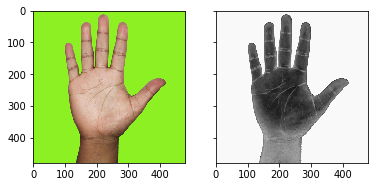

In [59]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].imshow(hand_rgb)
ax[1].imshow(s, cmap="gray")
plt.show()

# Edge detection: Canny

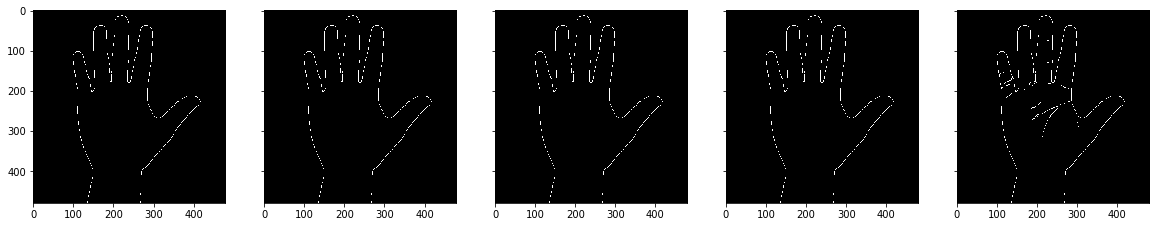

In [210]:
s_smoothed = cv2.GaussianBlur(s, (17, 17), sigmaX=sqrt(2), sigmaY=sqrt(2))
fig, ax = plt.subplots(1, 5, figsize=(20, 40), sharey=True)

ax[0].imshow(cv2.Canny(s_smoothed, 50, 150, True), cmap="gray")
ax[1].imshow(cv2.Canny(s_smoothed, 100, 400, True), cmap="gray")
ax[2].imshow(cv2.Canny(s_smoothed, 100, 300, True), cmap="gray")
ax[3].imshow(cv2.Canny(s_smoothed, 100, 200, True), cmap="gray")
ax[4].imshow(cv2.Canny(s_smoothed, 50, 100, True), cmap="gray")
plt.show()

# Threshold the fingers

The boundry is so perfect thus we cannot cut the fingers easily. Therefore, we should use Canny with a tolerant threshold.

In [211]:
# dilation
kernel_erode = np.ones((1,1),np.uint8)
kernel_dilate = np.ones((5,5), np.uint8)
hand_boundry = cv2.Canny(s_smoothed, 25, 70)
hand_boundry = cv2.erode(hand_boundry, kernel_erode, iterations=1)
hand_boundry = cv2.dilate(hand_boundry, kernel_dilate, iterations=1)

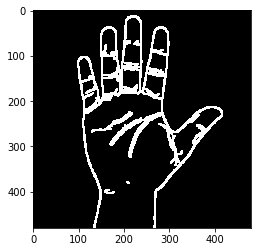

In [212]:
plt.imshow(hand_boundry, cmap="gray")
plt.show()

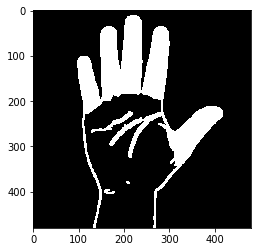

In [213]:
import scipy as sp
import scipy.ndimage

def flood_fill(test_array,h_max=255):
    input_array = np.copy(test_array) 
    el = sp.ndimage.generate_binary_structure(2,2).astype(np.int)
    inside_mask = sp.ndimage.binary_erosion(~np.isnan(input_array), structure=el)
    output_array = np.copy(input_array)
    output_array[inside_mask]=h_max
    output_old_array = np.copy(input_array)
    output_old_array.fill(0)   
    el = sp.ndimage.generate_binary_structure(2,1).astype(np.int)
    while not np.array_equal(output_old_array, output_array):
        output_old_array = np.copy(output_array)
        output_array = np.maximum(input_array,sp.ndimage.grey_erosion(output_array, footprint=el))
    return output_array

hand_boundry = flood_fill(hand_boundry)
plt.imshow(hand_boundry, cmap="gray")

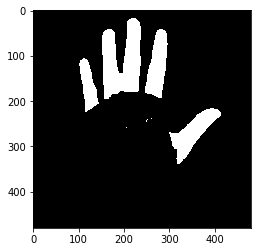

In [214]:
kernel_erode = np.ones((10,10),np.uint8)
hand_boundry = cv2.erode(hand_boundry, kernel_erode, iterations=1)
plt.imshow(hand_boundry, cmap="gray")

In [215]:
# use hand_boundry as mask to threshold the original image fingers
hand_fingers = cv2.bitwise_and(hand_rgb, hand_rgb, mask = hand_boundry)

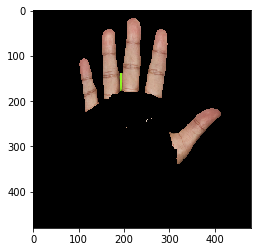

In [216]:
plt.imshow(hand_fingers)
plt.show()

In [306]:
green_mask = cv2.bitwise_and(hand_boundry, hand_fingers[:, :, 1])
_, green_mask = cv2.threshold(green_mask, 190, 1, cv2.THRESH_TOZERO_INV)

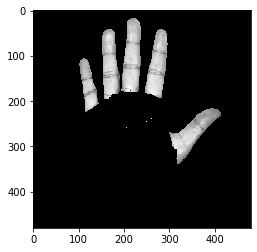

In [307]:
plt.imshow(green_mask, cmap="gray")

In [308]:
# clean the image
hand_fingers_cleaned = cv2.bitwise_and(hand_fingers, hand_fingers, mask = green_mask)

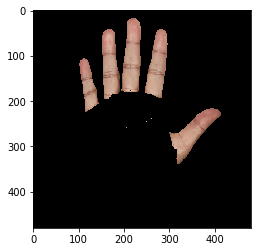

In [309]:
plt.imshow(hand_fingers_cleaned)
plt.show()

In [404]:
# remove small area
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(green_mask, connectivity=8)

# remove the small blocks
available_index = []
for i in range(nb_components):
    if stats[i][-1] < 30:
        output[output==i] = 0
    elif stats[i][0] > 0:
        available_index.append(i)
        
print(available_index)

[1, 2, 3, 4, 5]


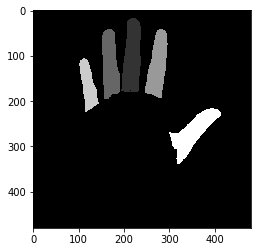

In [397]:
plt.imshow(output,cmap="gray")
plt.show()

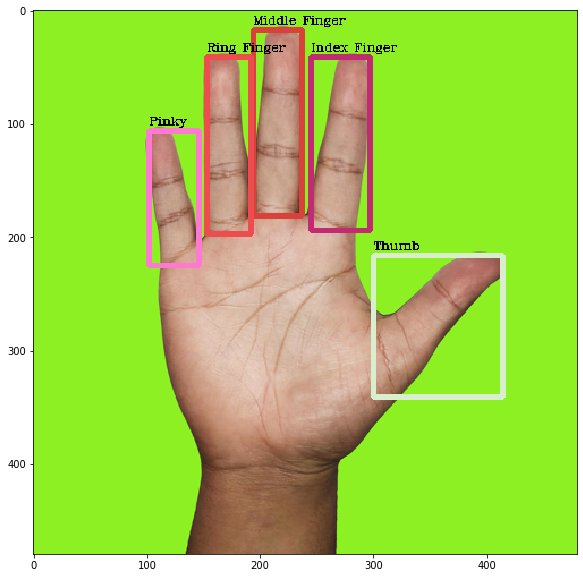

In [424]:
# draw a bounding box 
labels =["Pinky", "Ring Finger", "Middle Finger", "Index Finger", "Thumb"]
ordered_index = np.sort(stats[available_index, 0])
hand_with_box = hand_rgb.copy()
for i in available_index:
    box = stats[i]
    cv2.rectangle(hand_with_box, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), 3)
    label_index = np.argwhere(ordered_index == box[0])
    cv2.putText(hand_with_box, labels[label_index[0][0]], (box[0], box[1]-5), cv2.FONT_HERSHEY_COMPLEX, 0.35, (0, 0, 0), 1)
fig = plt.figure(figsize=(10, 10))
plt.imshow(hand_with_box)
plt.show()

In [425]:
box = stats[1]
box

array([ 194,   17,   43,  164, 5508], dtype=int32)

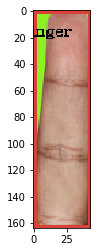

In [426]:
# the axis in cv2 and numpy is different. cv2 use horizental: x, vertical: y. data point (x, y) but numpy use vertical as x and horizental as y. data point (x,y)
plt.imshow(hand_with_box[box[1]: box[1] + box[3], box[0]: box[0] + box[2]])

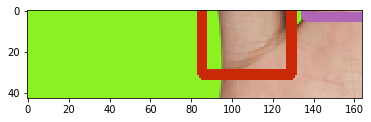

In [419]:
plt.imshow(hand_with_box[box[0]: box[0] + box[2], box[1]: box[1] + box[3]])